In [1]:
import librosa
import numpy as np
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import MaxAbsScaler

In [2]:
mel_list = []
sound = glob.glob('C:\\Users\\vislab\\Documents\\DOLearn\\permission to safe\\jupyter\\audio\\*.wav',recursive=True)
label = pd.read_csv('C:\\Users\\vislab\\Documents\\DOLearn\\permission to safe\\jupyter\\y_label.csv')
i = 1


In [15]:
import librosa.display
librosa.display.waveplot()

AttributeError: module 'librosa.display' has no attribute 'waveplot'

In [3]:
label #0이 위험 / 1이 일상생활

,0
0,0
1,0
2,0
3,0
4,0
...,...
327,0
328,0
329,0
330,0


In [4]:
for fname in sound:

    i += 1
    audio_signal, sample_rate = librosa.load(fname, duration=10, sr=48000)
    # print(len(audio_signal))
    signal = np.zeros(int(48000 * 10 + 1, ))
    signal[:len(audio_signal)] = audio_signal

    mel_spec = librosa.feature.melspectrogram(y=signal,
                                              sr=48000,
                                              n_fft=1024,
                                              win_length=512,
                                              window='hamming',
                                              hop_length=256,
                                              n_mels=128,
                                              fmax=sample_rate / 2
                                              )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_list.append(mel_spec_db)
    # print(mel_spec_db.shape)

    if (i % 100 == 0):
        print(i)

100
200
300


In [8]:
#time domain에서 분석

import matplotlib.pyplot as plt
import librosa.display


for fname in sound:
    plt.figure(figsize=(10, 5))
    librosa.display.waveplot(fname, sr=48000, alpha=0.5) # 파형의 진폭(소리의 크기) 표시 
    # sr을 따로 설정해주지 않으면 librosa는 default인 22050
    # sr==sample rate : 평소에 듣는 소리인 아날로그 신호를 숫자화 (디지털화) 시킨것. Sampling을 할 때 1초에 몇 개의 sample을 추출하여 사용할 것인지 나타낸 것.
    # sample rate가 클수록 원본 사운드와 유사한 표현을 할 수 있지만, 더 많은 메모리 공간을 차지함.
    # 사람의 가청 주파수는 20khz정도. 이는 40khz의 샘플을 필요로함.
    # 그런데 노이즈를 줄이기 위해서 주파수를 높임 -> 44.1khz, 48khz..
    # 오디오 표준 sr은 44.1khz == 1 sec 당 44100번의 samples를 기록. 근데 이건 48000 이용

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")


#--------------------------------------------------
#Fourier -> Spectrum

    fft = np.fft.fft(fname) # 푸리에 변환시킴 : 시간이나 공간에 대한 함수를 시간 또는 공간 주파수 성분으로 분해하는 변환
    print("fft",fft)
    # fft : fast Fourier transform 
    # time domain 에서 frequency domain으로 변환 시킴.
    # 이렇게 frequency doamin으로 변환된 정보를 spectrum이라고 함. 해당 spectrum에는 고유 배음구조가 존재, 이를 유추함으로써 소리의 고유한 특징을 설계할 수 있음.

    magnitude = np.abs(fft) #절댓값 취함
    print("magnitude",magnitude)
    # magnitude 그래프를 만들기 위해 복소수 타입인 fft에 절댓값 취함.

    f = np.linspace(0,48000,len(magnitude)) # linspace(start,stop,num) : 1차원 배열 만들기
    print("f",f)
    print("f len",len(f))
    # 0에서 48000까지 magnitude 길이 만큼 1차원 배열인 f 만듬


    # 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날리고 앞쪽 절반만 사용한다.
    left_spectrum = magnitude[:int(len(magnitude) / 2)]
    left_f = f[:int(len(magnitude) / 2)]

    plt.figure()
    plt.plot(left_f, left_spectrum)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Power spectrum")

    #대칭임을 보임
    plt.figure()
    plt.plot(f, magnitude)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title("Power spectrum")

#-------------------------------------------------
#STFT -> spectrogram
# fft를 사용하면 time dependent한 신호의 특성상 시간적 정보를 이용할 수 없다.
# 각각의 frame마다 fft를 적용하여 다시 시간 순서로 이어붙임으로써 시간적 특성까지 고려한 spectrum을 구할 수 있음 -> STFT(Short Time Fourier Transform)
# STFT를 통해 spectrum이 지니고 있는 frequency 정보와 magnitude 정보 뿐만 아니라 time frame 정보까지 존재하는 데이터를 만들 수 있으며 이를 spectrogram이라 정의.
# spectrogram은 소리나 파동을 시가고하하여 파악하기 위한 도구로, 파형(waveform)과 스펙트럼(spectrum)의 특징이 조합되어 있다.
# waveform -> time축의 변화에 따른 Amplitude(진폭)축의 변화.
# spectrum -> frequeuncy 축의 변화에 따른 Amplitude 축의 변화.
# spectrogram -> time 축과 frequency 축의 변화에 따라 amplitude의 차이를 인쇄 농도 / 표시 색상의 차이로 나타냄.


    hop_length = 256 # default는 n_fft/4 # hop_length는 음성의 magnitude를 얼만큼 겹친 상태로 잘라서 칸으로 보여줄 것인가
    n_fft = 1024 # 22050Hz일때 512 추천 -> 48000이니 1024 사용. # n_fft는 음성의 길이를 얼마만큼으로 자를 것인가. 이를 window라고 부른다
    # 이때, window의 크기(n_fft)와 window 간에 겹치는 사이즈(hop_length)를 설정해줍니다. 일반적으로는 n_fft의 1/4 정도가 겹치도록 설정한다고 합니다.


    hop_length_duration = float(hop_length) / 48000
    n_fft_duration = float(n_fft) / 48000

    stft = librosa.stft(fname, n_fft=n_fft, hop_length=hop_length)

    magnitude = np.abs(stft)

    log_spectrogram = librosa.amplitude_to_db(magnitude) # amplitude spectrogram을 dB-scaled spectrogram으로 변환

    plt.figure()
    librosa.display.specshow(log_spectrogram, sr=48000, hop_length=hop_length, x_axis='time')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram (dB)") #진폭 amplitude # db 데시벨. 





AttributeError: module 'librosa.display' has no attribute 'waveplot'

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Power spectrum')

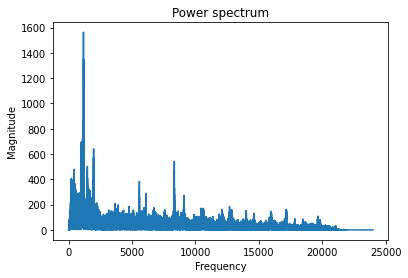

In [ ]:
# Fourier -> Spectrum

fft = np.fft.fft(audio_signal)

magnitude = np.abs(fft) 

f = np.linspace(0,48000,len(magnitude))

left_spectrum = magnitude[:int(len(magnitude) / 2)]
left_f = f[:int(len(magnitude) / 2)]

plt.figure()
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

Text(0.5, 1.0, 'Spectrogram (dB)')

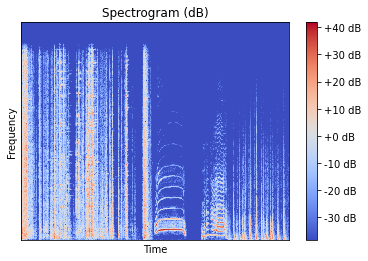

In [ ]:
# STFT -> spectrogram

hop_length = 256
n_fft = 1024

hop_length_duration = float(hop_length) / 48000
n_fft_duration = float(n_fft) / 48000

stft = librosa.stft(audio_signal, n_fft=n_fft, hop_length=hop_length)

magnitude = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure()
librosa.display.specshow(log_spectrogram, sr=48000, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

In [ ]:
signal = np.zeros(int(48000 * 10 + 1, ))
signal[:len(audio_signal)] = audio_signal

mel_spec = librosa.feature.melspectrogram(y=signal,
                                          sr=48000,
                                          n_fft=1024,
                                          win_length=512,
                                          window='hamming',
                                          hop_length=256,
                                          n_mels=128,
                                          fmax=sample_rate / 2
                                          )
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
mel_list.append(mel_spec_db)
print(mel_spec_db.shape)

(128, 1876)


In [ ]:
# mel-spectrogram
# 사람은 high frequency 보다 low frequency에 더 민감하게 반응. 이러한 사람의 청각기관을 모데링한하여 표현한 것이 Mel Scale.
# STFT를 통해 구한 spectrogram에 mel-filter를 적용함으로써 mel-scale로 spectrogram을 바꿈.

import cv2

frame_length = 0.025
frame_stride = 0.010

def Mel_S(wav_file):
    # mel-spectrogram
    y, sr = librosa.load(wav_file, sr=48000)

    # wav_length = len(y)/sr
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))

    S = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)

    #plt.figure(figsize=(10, 4))
    plt.imshow(cv2.flip(librosa.power_to_db(S, ref=np.max),0))
    plt.savefig('Mel-Spectrogram example.png')



    
    print("Wav length: {}, Mel_S shape:{}".format(len(y)/sr,np.shape(S)))

Wav length: 1.2798958333333332, Mel_S shape:(40, 128)


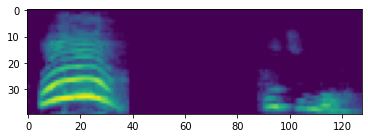

In [ ]:
Mel_S('/content/gdrive/MyDrive/만번만승/1.강제추행(성범죄)_105095_label.wav') #->128칸 얻는다.